In [2]:
!pip install datasets transformers pandas torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 66.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [5]:
dataset = load_dataset("zeroshot/twitter-financial-news-topic")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [9]:
# Data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [11]:
splits = ['train', 'validation']
for split in splits:
    print(f"Processing {split} split...")
    df = pd.DataFrame(dataset[split])
    df['clean_text'] = df['text'].apply(clean_text)
    df['text_length'] = df['clean_text'].apply(len)

Processing train split...
Processing validation split...


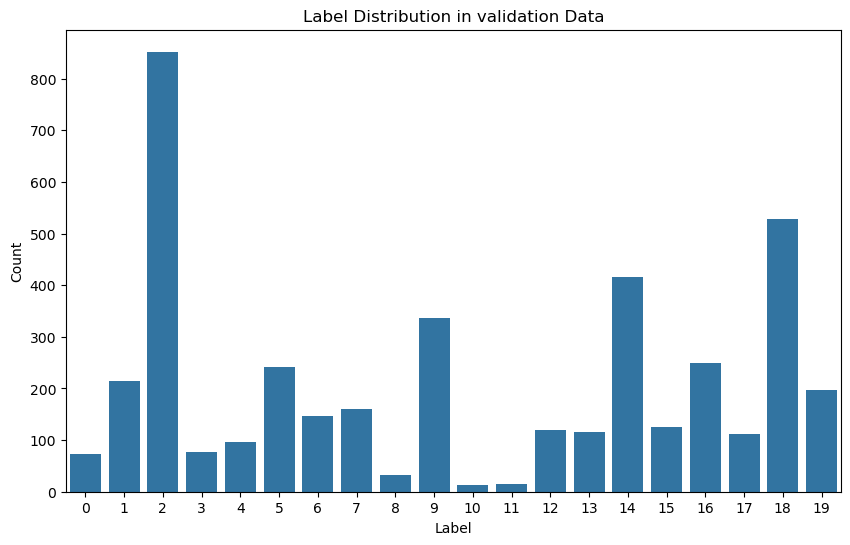

In [18]:
    # Plot the distribution of labels
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label')
    plt.title(f'Label Distribution in {split} Data')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

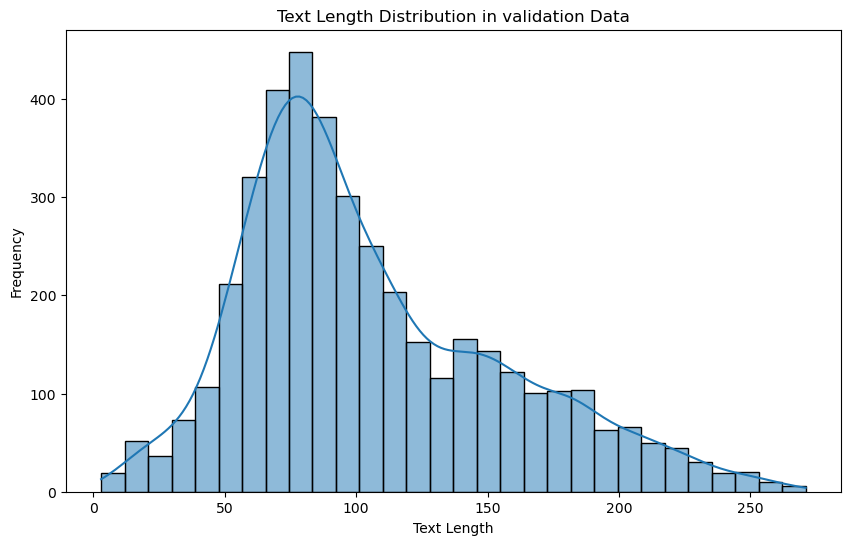

In [15]:
    # Plot the distribution of text lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], bins=30, kde=True)
    plt.title(f'Text Length Distribution in {split} Data')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

In [17]:
unique_labels = df['label'].unique()
print(f"Unique labels in {split} data: {unique_labels}")

Unique labels in validation data: [ 0  2  9  8  4  5  6  1  7 10 11 12 13 14 15 17 16 18 19  3]


In [ ]:
# SageMaker training job setup
role = sagemaker.get_execution_role()
pytorch_estimator = PyTorch(entry_point='train.py',
                            source_dir='.',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.m5.2xlarge',
                            hyperparameters={'epochs': 1},
                            use_spot_instances=True,
                            max_run=3600,  # Maximum runtime in seconds
                            max_wait=7200)  # Maximum wait time for Spot Instances 

# Start the training job
pytorch_estimator.fit()

In [14]:
# SageMaker validation job setup
import sagemaker
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

# Define the processor
pytorch_processor = PyTorchProcessor(
    framework_version='1.7.1',
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    command=['python3'],
)

# Use the processor
pytorch_processor.run(
    code='test.py',
    source_dir='.',
    inputs=[ProcessingInput(
        source='./model', 
        destination='/opt/ml/processing/model'
    )],
    arguments=['--arg1', 'value1'],
)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded . to s3://sagemaker-us-east-1-532114563603/pytorch-2024-03-26-07-33-09-103/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-532114563603/pytorch-2024-03-26-07-33-09-103/source/runproc.sh
INFO:sagemaker:Creating processing-job with name pytorch-2024-03-26-07-33-09-103


  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-py3-none-any.whl size=3160 sha256=3f29978d0cc26ab2d823b4941ee38b552e52a162111428f5cdc9086f6754f0c3
  Stored in directory: /root/.cache/pip/wheels/6a/f5/9c/f8331a854f7a8739cf0e74c13854e4dd7b1af11b04fe1dde13
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895254 sha256=c666350d13571ffeb8db5fe24e6783f624baca3cb8509ac875820a275448b91d
  Stored in directory: /root/.cache/pip/wheels/4c/64/31/e9900a234b23fb3e9dc565d6114a9d6ff84a72dbdd356502b4
Successfully built idna-ssl sacremoses
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.5.0
    Uninstalling fsspec-2021.5.0:
      Successfully uninstalled fsspec-2021.5.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 4.0.0
    Uninstalling pyarrow-4.0.0:
      Successfu